# Model Selection

Within this workbook we'll evaluate three classical machine learning models given the metric data generated within the last few workbooks. We'll iterate through these models with a GridSearch to determine the optimal parameters. Finally, the results of the best model will be determined and a confusion matrix will be printed.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import os
import json
import seaborn as sns

from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,classification_report,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import normalize,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D,LeakyReLU
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow import keras


from tqdm import tqdm

import librosa
from scipy.stats import skew

## Data Imports

In [49]:
# with open('pickles/df_concat.pkl', 'rb') as f:
#     df_concat = pickle.load(f)

# with open('pickles/df_torch.pkl', 'rb') as f:
#     df_torch = pickle.load(f)
    
with open('pickles/df_model.pkl', 'rb') as f:
    df_model = pickle.load(f)

### Random Sampling

We'll be random sampling 50% of the data to accelerate our gridsearch. We'll apply the results of the gridsearch to the whole data and compare the results in the final model. We'll be monitoring this, as it's important to gather a representative sample of the data.

In [54]:
df_model = df_model.sample(frac=.50, random_state=2023)

In [55]:
df_model.shape

(65952, 62)

### Identifying Target Variable

In [56]:
df_model = df_model.dropna()

In [57]:
X = df_model.drop(columns = ['modelId','filename'],axis=1)
y = df_model['modelId']

### Train Test Split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023, shuffle=True)

### Scaling the Data

In [59]:
scaler = StandardScaler()
Z_train = scaler.fit_transform(X_train)
Z_test = scaler.transform(X_test)

### Null Model

Before we model our data, we need to establish a null model that we will use as a benchmark for the efficacy of our model.

In [60]:
null_model = y.value_counts(normalize = True)
null_model

0    0.664341
1    0.335659
Name: modelId, dtype: float64

From the above counts, our data is balanced and our null model indicates that the baseline accuracy is 67%

In [61]:
y.shape, y_train.shape, y_test.shape, Z_train.shape, Z_test.shape, X_train.shape,X_test.shape

((65942,),
 (52753,),
 (13189,),
 (52753, 60),
 (13189, 60),
 (52753, 60),
 (13189, 60))

### Random Forest

In [62]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [63]:
model_rf = RandomForestClassifier()

In [64]:
grid_search = GridSearchCV(model_rf, param_grid, cv=5, n_jobs=-1, verbose=2)

for i in tqdm(range(100)):
    grid_search.fit(Z_train, y_train)
    cv_results = grid_search.cv_results_
    rank = cv_results['rank_test_score'][grid_search.best_index_]
    print("Rank of best hyperparameters:", rank)

print("Best hyperparameters:", grid_search.best_params_)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Fitting 5 folds for each of 162 candidates, totalling 810 fits


  0%|                                                   | 0/100 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print("Best parameter values:", grid_search.best_params_)

Best parameter values: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(Z_test)

print(classification_report(y_test, y_pred))

In [ ]:
importances = RandomForestClassifier().fit(Z_train, y_train).feature_importances_

In [ ]:
plt.barh(X.columns, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [ ]:
corr_matrix = df_model.corr()

In [ ]:
sns.heatmap(corr_matrix, annot=False);

### Logistic Regression

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'saga'],
}

In [ ]:
model_lr = LogisticRegression(max_iter=10000)

In [ ]:
grid_search = GridSearchCV(model_lr, param_grid, cv=5, n_jobs=-1, verbose=0)
model_lr.fit(Z_train, y_train)

In [ ]:
print("Best parameter values:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(Z_test)

In [ ]:
y_pred = model_lr.predict(X_test)

class_report = classification_report(y_test, y_pred)
print(class_report)

In [ ]:
print(classification_report(y_test, y_pred))

### SVM

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + [0.1, 1, 10],
    'shrinking': [True, False],
    'class_weight': [None, 'balanced']
}

In [ ]:
model_svm = SVC()

In [ ]:
model_svm.fit(Z_train,y_train)

In [ ]:
grid_search = GridSearchCV(model_svm, param_grid, cv=5,n_jobs=-1, verbose=1)
grid_search.fit(Z_train, y_train)

In [ ]:
print("Best parameter values:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(Z_test)

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

In [ ]:
print(classification_report(y_test, y_pred))

### Final Models

In [93]:
with open('pickles/df_model.pkl', 'rb') as f:
    df_model = pickle.load(f)

In [94]:
df_model.columns

Index(['filename', 'modelId', 'mfccs_0', 'mfccs_1', 'mfccs_2', 'mfccs_3',
       'mfccs_4', 'mfccs_5', 'mfccs_6', 'mfccs_7', 'mfccs_8', 'mfccs_9',
       'mfccs_10', 'mfccs_11', 'mfccs_12', 'chroma_0', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'spectral_centroids_0', 'spectral_centroids_1',
       'spectral_centroids_2', 'spectral_centroids_3', 'spectral_centroids_4',
       'spectral_bandwidth_0', 'spectral_bandwidth_1', 'spectral_bandwidth_2',
       'spectral_bandwidth_3', 'spectral_bandwidth_4', 'spectral_flux_0',
       'spectral_flux_1', 'spectral_flux_2', 'spectral_flux_3',
       'spectral_flux_4', 'spectral_flux_5', 'spectral_flux_6',
       'spectral_flux_7', 'spectral_flux_8', 'spectral_flux_9', 'mel_spec_0',
       'mel_spec_1', 'mel_spec_2', 'mel_spec_3', 'mel_spec_4', 'mel_spec_5',
       'mel_spec_6', 'mel_spec_7', 'mel_spec_8', 'mel_spec_9', 'mfccs_mean',
       'spectral_centroids_mean', 's

In [95]:
df_model = df_model.dropna()

X = df_model.drop(columns = ['modelId','filename','chroma_mean','chroma_3','chroma_4','chroma_5','chroma_6','mfccs_mean','chroma_2','chroma_7'],axis=1)
y = df_model['modelId']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023, shuffle=True)

In [97]:
scaler = StandardScaler()
Z_train = scaler.fit_transform(X_train)
Z_test = scaler.transform(X_test)

#### Random Forest (Best Model)

In [98]:
model_rf = RandomForestClassifier()

In [99]:
model_rf.fit(Z_train, y_train)

RandomForestClassifier()

In [100]:
y_pred = model_rf.predict(Z_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     17668
           1       0.85      0.84      0.85      8710

    accuracy                           0.90     26378
   macro avg       0.89      0.89      0.89     26378
weighted avg       0.90      0.90      0.90     26378



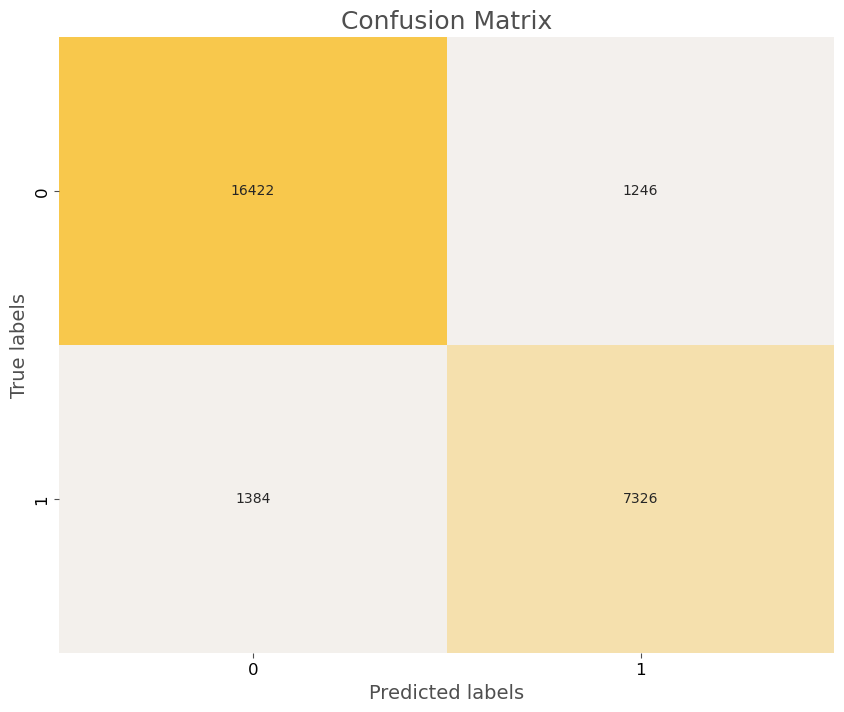

In [101]:
# Create a heatmap visualization
yellow = '#f8c84c'
grey = '#4F4F4F'
background = '#e8e4e4'

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, cmap=sns.light_palette(yellow, as_cmap=True), annot=True, fmt='g', cbar=False, ax=ax)

# Set the axis labels and title
ax.set_xlabel('Predicted labels', fontsize=14, color=grey)
ax.set_ylabel('True labels', fontsize=14, color=grey)
ax.set_title('Confusion Matrix', fontsize=18, color=grey)

# Set the color of the axis ticks
ax.tick_params(axis='both', which='major', labelsize=12, color=grey)
plt.show()

In [102]:
importances = RandomForestClassifier().fit(Z_train, y_train).feature_importances_

In [103]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=True)

In [104]:
feature_importances.head(10)

,feature,importance
36,spectral_flux_9,0.008016
35,spectral_flux_8,0.008053
48,spectral_bandwidth_mean,0.008080
24,spectral_bandwidth_2,0.008529
49,zero_crossing_rate_mean,0.008576
34,spectral_flux_7,0.008683
5,mfccs_5,0.009297
25,spectral_bandwidth_3,0.009575
44,mel_spec_7,0.009851
46,mel_spec_9,0.009884


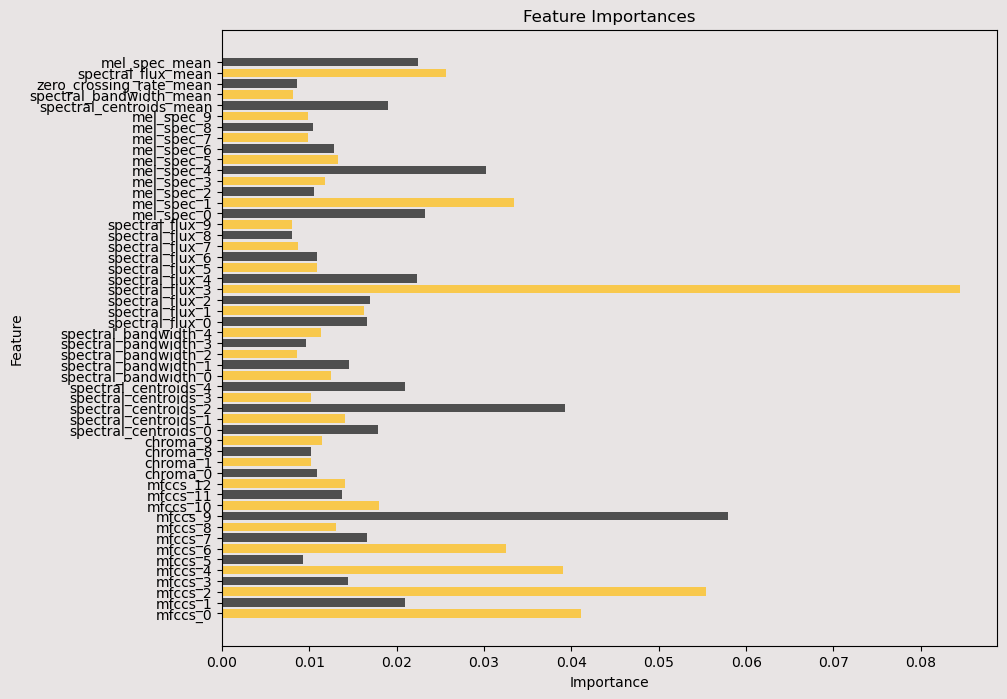

In [111]:
yellow = '#f8c84c'
grey = '#4F4F4F'
background = '#e8e4e4'

# Set the figure size and background color
plt.figure(figsize=(10, 8), facecolor=background)

# Create the horizontal bar chart with the yellow-gray color scheme
ax = plt.barh(X.columns, importances, color=[yellow if i % 2 == 0 else grey for i in range(len(X.columns))])

# Set the face color of the plot to match the background color
ax[0].axes.set_facecolor(background)

# Set the axis labels and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')

# Show the plot
plt.show()

#### Logistic Regression

In [21]:
model_lr = LogisticRegression(max_iter=10000)

In [22]:
model_lr.fit(Z_train,y_train)

LogisticRegression(max_iter=10000)

In [24]:
y_pred = model_lr.predict(Z_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86     17668
           1       0.72      0.67      0.69      8710

    accuracy                           0.80     26378
   macro avg       0.78      0.77      0.77     26378
weighted avg       0.80      0.80      0.80     26378



#### Support Vector Machine


In [25]:
model_svm = SVC()

In [26]:
model_svm.fit(Z_train,y_train)

SVC()

In [27]:
y_pred = model_svm.predict(X_test)

print(classification_report(y_test, y_pred))

/Users/ryan/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.79      0.96      0.87     17668
           1       0.85      0.48      0.61      8710

    accuracy                           0.80     26378
   macro avg       0.82      0.72      0.74     26378
weighted avg       0.81      0.80      0.78     26378

